In [3]:
import os
import re

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
metadata = json.load(open('/Users/erikstorrs/Documents/ding/cell-segmentation/data/box.json'))

In [2]:
image_fp = '../data/NaKATPase/F_1199_07_p005.png'

## convert one channel grayscale to three channel grayscale

(2160, 2560)


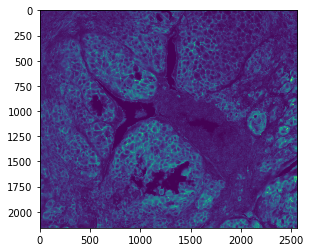

In [6]:
gray_image = cv2.imread(image_fp, cv2.IMREAD_GRAYSCALE)

print(gray_image.shape)

plt.imshow(gray_image)

(2160, 2560, 3)


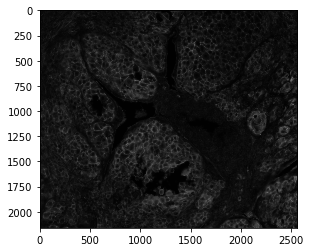

In [7]:
rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)

print(rgb_image.shape)

plt.imshow(rgb_image)

## chop image up into pieces

In [8]:
row_size = 512
col_size = 512

In [9]:
images = []

prev_r = 0
prev_c = 0
for i, r in enumerate(range(0, rgb_image.shape[0], row_size)):
    for j, c in enumerate(range(0, rgb_image.shape[1], col_size)):
        if r and c:
            images.append(((i, j), rgb_image[prev_r:r, prev_c:c, :]))
        prev_c = c
    prev_r = r

In [10]:
len(images)

16

In [7]:
def chop_image(rgb_image, row_size=512, col_size=512):
    images = {}

    prev_r = 0
    prev_c = 0
    for i, r in enumerate(range(0, rgb_image.shape[0], row_size)):
        for j, c in enumerate(range(0, rgb_image.shape[1], col_size)):
            if r and c:
                images[(i, j)] = rgb_image[prev_r:r, prev_c:c, :]
            prev_c = c
        prev_r = r
        
    return images

## view side by side

In [53]:
yellow = np.uint8([[[255,255,255]]])
hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
hsv_yellow

array([[[  0,   0, 255]]], dtype=uint8)

In [8]:
metadata['F_1199_07'].keys()

dict_keys(['P002', 'P004', 'P003', 'P005', 'P001', 'P000', 'P006'])

In [6]:
from PIL import Image
# from transforms import RGBTransform

In [21]:
# dapi_image_fp = '../data/dapi/F_1199_07_p005.png'
# NaKATPase_image_fp = '../data/NaKATPase/F_1199_07_p005.png'

dapi_image_fp = [x['filepath'] for x in metadata['F_1199_07']['P000'] if x['channel'] == 'dapi'][0]
NaKATPase_image_fp = [x['filepath'] for x in metadata['F_1199_07']['P000'] if x['channel'] == 'NaKATPase'][0]


In [22]:
# convert to 3 channels
gray_image = cv2.imread(dapi_image_fp, cv2.IMREAD_GRAYSCALE)
dapi_rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
dapi_blue_image = cv2.cvtColor(dapi_rgb_image, cv2.COLOR_BGR2HSV)

gray_image = cv2.imread(NaKATPase_image_fp, cv2.IMREAD_GRAYSCALE)
NaKATPase_rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
hsv = cv2.cvtColor(NaKATPase_rgb_image, cv2.COLOR_BGR2HSV)

# # define range of blue color in HSV
# lower_blue = np.array([0, 100, 100])
# upper_blue = np.array([20, 255, 255])
# # Threshold the HSV image to get only blue colors
# mask = cv2.inRange(hsv, lower_blue, upper_blue)
# # Bitwise-AND mask and original image
# res = cv2.bitwise_and(NaKATPase_rgb_image,NaKATPase_rgb_image, mask= mask)


# gray_image = Image.open(NaKATPase_image_fp)
# NaKATPase_rgb_image = gray_image.convert('RGB')
# NaKATPase_yellow_image = RGBTransform().mix_with((255,255,51),factor=.20).applied_to(NaKATPase_rgb_image)


In [23]:
# fig, axs = plt.subplots(1,2, figsize=(18,18))
# axs[0].imshow(dapi_blue_image)
# axs[1].imshow(NaKATPase_yellow_image)

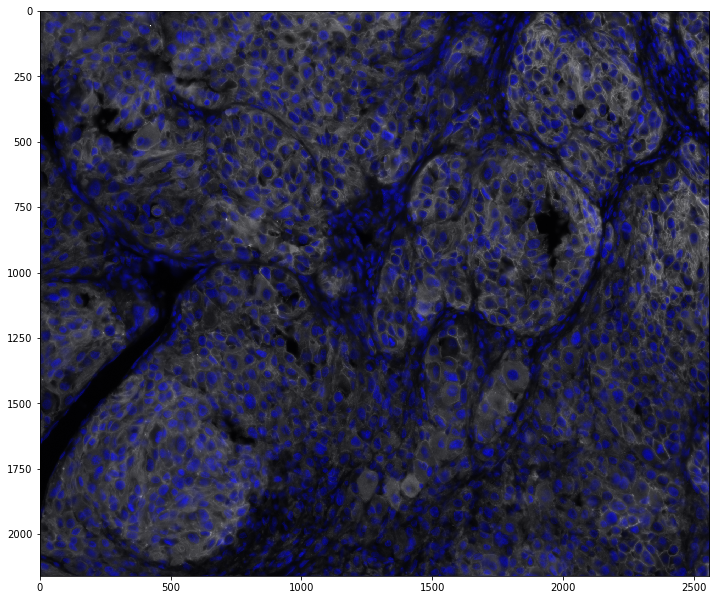

In [24]:
img = cv2.addWeighted(dapi_blue_image, 0.3, NaKATPase_rgb_image, 0.7, 0)
img = cv2.add(dapi_blue_image, NaKATPase_rgb_image)

plt.figure(figsize = (12,12))
plt.imshow(img)
plt.imsave('test.png', img)

## run individual grayscale and chop workflow

In [11]:
# input_images_dir = '../data/dapi/'
# output_images_dir = '../data/dapi_processed'

input_images_dir = '../data/NaKATPase/'
output_images_dir = '../data/NaKATPase_processed'

In [12]:
## make output directory
os.mkdir(output_images_dir)

FileExistsError: [Errno 17] File exists: '../data/NaKATPase_processed'

In [13]:
input_image_fps = [os.path.join(input_images_dir, fp)
               for fp in os.listdir(input_images_dir)]

len(input_image_fps), input_image_fps[:5]

(3,
 ['../data/NaKATPase/F_1199_07_p006.png',
  '../data/NaKATPase/F_1199_07_p004.png',
  '../data/NaKATPase/F_1199_07_p005.png'])

In [14]:
for image_fp in input_image_fps:
    image_id = image_fp.split('/')[-1].replace('.png', '')
    
    # make output dir
    if not os.path.isdir(os.path.join(output_images_dir, image_id)):
        os.mkdir(os.path.join(output_images_dir, image_id))
        os.mkdir(os.path.join(output_images_dir, f'{image_id}_test'))
    
    # convert to 3 channels
    gray_image = cv2.imread(image_fp, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    
    # split up image
    location_to_image_chunks = chop_image(rgb_image, row_size=256, col_size=256)
    
    for (i, j), image_chunk in location_to_image_chunks.items():
        if not os.path.isdir(os.path.join(output_images_dir, image_id, f'{image_id}_{i}_{j}')):
            os.mkdir(os.path.join(output_images_dir, f'{image_id}_test', f'{image_id}_{i}_{j}'))
            os.mkdir(os.path.join(output_images_dir, f'{image_id}_test', f'{image_id}_{i}_{j}', 'images'))
            
        plt.imsave(os.path.join(output_images_dir, image_id, f'{image_id}_{i}_{j}.png'), image_chunk)
        plt.imsave(os.path.join(output_images_dir,
                f'{image_id}_test', f'{image_id}_{i}_{j}', 'images', f'{image_id}_{i}_{j}.png'), image_chunk)

## run combined grayscale and chop workflow


In [57]:
dapi_input_images_dir = '../data/dapi/'
nakatpase_input_images_dir = '../data/NaKATPase/'

output_images_dir = '../data/dapi_NaKATPase_combined_processed'

In [58]:
## make output directory
os.mkdir(output_images_dir)

FileExistsError: [Errno 17] File exists: '../data/dapi_NaKATPase_combined_processed'

In [59]:
dapi_input_image_fps = sorted([os.path.join(dapi_input_images_dir, fp)
               for fp in os.listdir(dapi_input_images_dir)])

len(dapi_input_image_fps), dapi_input_image_fps[:5]

(3,
 ['../data/dapi/F_1199_07_p004.png',
  '../data/dapi/F_1199_07_p005.png',
  '../data/dapi/F_1199_07_p006.png'])

In [60]:
nakatpase_input_image_fps = sorted([os.path.join(nakatpase_input_images_dir, fp)
               for fp in os.listdir(nakatpase_input_images_dir)])

len(nakatpase_input_image_fps), nakatpase_input_image_fps[:5]

(3,
 ['../data/NaKATPase/F_1199_07_p004.png',
  '../data/NaKATPase/F_1199_07_p005.png',
  '../data/NaKATPase/F_1199_07_p006.png'])

In [66]:
for dapi_fp, nakatpase_fp in zip(dapi_input_image_fps, nakatpase_input_image_fps):
    image_id = dapi_fp.split('/')[-1].replace('.png', '')
    
    # make output dir
    if not os.path.isdir(os.path.join(output_images_dir, image_id)):
        os.mkdir(os.path.join(output_images_dir, image_id))
        
    # make test output dir
    if not os.path.isdir(os.path.join(output_images_dir, f'{image_id}_test')):
        os.mkdir(os.path.join(output_images_dir, f'{image_id}_test'))
    
    # convert to 3 channels
    gray_image = cv2.imread(dapi_fp, cv2.IMREAD_GRAYSCALE)
    dapi_rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    gray_image = cv2.imread(nakatpase_fp, cv2.IMREAD_GRAYSCALE)
    nakatpase_rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    
    # split up image
    dapi_location_to_image_chunks = chop_image(dapi_rgb_image, row_size=256, col_size=256)
    nakatpase_location_to_image_chunks = chop_image(nakatpase_rgb_image, row_size=256, col_size=256)
    
    for (i, j) in dapi_location_to_image_chunks.keys():
        dapi_image_chunk = dapi_location_to_image_chunks[(i, j)]
        nakatpase_image_chunk = nakatpase_location_to_image_chunks[(i, j)]
        
        dapi_blue_image = cv2.cvtColor(dapi_image_chunk, cv2.COLOR_BGR2HSV)
        img = cv2.add(dapi_blue_image, nakatpase_image_chunk)
        
        plt.imsave(os.path.join(output_images_dir, image_id, f'{image_id}_{i}_{j}.png'), img)
        
        os.mkdir(os.path.join(output_images_dir, f'{image_id}_test', f'{image_id}_{i}_{j}'))
        os.mkdir(os.path.join(output_images_dir, f'{image_id}_test', f'{image_id}_{i}_{j}', 'images'))
        plt.imsave(os.path.join(output_images_dir, f'{image_id}_test',
                                f'{image_id}_{i}_{j}', 'images', f'{image_id}_{i}_{j}.png'), img)
        
        
        
        
        
        

#### set up predictions directory

In [23]:
"""A library for describing and applying affine transforms to PIL images."""
import numpy as np
import PIL.Image


class RGBTransform(object):
    """A description of an affine transformation to an RGB image.
    This class is immutable.
    Methods correspond to matrix left-multiplication/post-application:
    for example,
        RGBTransform().multiply_with(some_color).desaturate()
    describes a transformation where the multiplication takes place first.
    Use rgbt.applied_to(image) to return a converted copy of the given image.
    For example:
        grayish = RGBTransform.desaturate(factor=0.5).applied_to(some_image)
    """

    def __init__(self, matrix=None):
        self._matrix = matrix if matrix is not None else np.eye(4)

    def _then(self, operation):
        return RGBTransform(np.dot(_embed44(operation), self._matrix))

    def desaturate(self, factor=1.0, weights=(0.299, 0.587, 0.114)):
        """Desaturate an image by the given amount.
        A factor of 1.0 will make the image completely gray;
        a factor of 0.0 will leave the image unchanged.
        The weights represent the relative contributions of each channel.
        They should be a 1-by-3 array-like object (tuple, list, np.array).
        In most cases, their values should sum to 1.0
        (otherwise, the transformation will cause the image
        to get lighter or darker).
        """
        weights = _to_rgb(weights, "weights")

        # tile: [wr, wg, wb]  ==>  [[wr, wg, wb], [wr, wg, wb], [wr, wg, wb]]
        desaturated_component = factor * np.tile(weights, (3, 1))
        saturated_component = (1 - factor) * np.eye(3)
        operation = desaturated_component + saturated_component

        return self._then(operation)

    def multiply_with(self, base_color, factor=1.0):
        """Multiply an image by a constant base color.
        The base color should be a 1-by-3 array-like object
        representing an RGB color in [0, 255]^3 space.
        For example, to multiply with orange,
        the transformation
            RGBTransform().multiply_with((255, 127, 0))
        might be used.
        The factor controls the strength of the multiplication.
        A factor of 1.0 represents straight multiplication;
        other values will be linearly interpolated between
        the identity (0.0) and the straight multiplication (1.0).
        """
        component_vector = _to_rgb(base_color, "base_color") / 255.0
        new_component = factor * np.diag(component_vector)
        old_component = (1 - factor) * np.eye(3)
        operation = new_component + old_component

        return self._then(operation)

    def mix_with(self, base_color, factor=1.0):
        """Mix an image by a constant base color.
        The base color should be a 1-by-3 array-like object
        representing an RGB color in [0, 255]^3 space.
        For example, to mix with orange,
        the transformation
            RGBTransform().mix_with((255, 127, 0))
        might be used.
        The factor controls the strength of the color to be added.
        If the factor is 1.0, all pixels will be exactly the new color;
        if it is 0.0, the pixels will be unchanged.
        """
        base_color = _to_rgb(base_color, "base_color")
        operation = _embed44((1 - factor) * np.eye(3))
        operation[:3, 3] = factor * base_color

        return self._then(operation)

    def get_matrix(self):
        """Get the underlying 3-by-4 matrix for this affine transform."""
        return self._matrix[:3, :]

    def applied_to(self, image):
        """Apply this transformation to a copy of the given RGB* image.
        The image should be a PIL image with at least three channels.
        Specifically, the RGB and RGBA modes are both supported, but L is not.
        Any channels past the first three will pass through unchanged.
        The original image will not be modified;
        a new image of the same mode and dimensions will be returned.
        """

        # PIL.Image.convert wants the matrix as a flattened 12-tuple.
        # (The docs claim that they want a 16-tuple, but this is wrong;
        # cf. _imaging.c:767 in the PIL 1.1.7 source.)
        matrix = tuple(self.get_matrix().flatten())

        channel_names = image.getbands()
        channel_count = len(channel_names)
        if channel_count < 3:
            raise ValueError("Image must have at least three channels!")
        elif channel_count == 3:
            return image.convert('RGB', matrix)
        else:
            # Probably an RGBA image.
            # Operate on the first three channels (assuming RGB),
            # and tack any others back on at the end.
            channels = list(image.split())
            rgb = PIL.Image.merge('RGB', channels[:3])
            transformed = rgb.convert('RGB', matrix)
            new_channels = transformed.split()
            channels[:3] = new_channels
            return PIL.Image.merge(''.join(channel_names), channels)

    def applied_to_pixel(self, color):
        """Apply this transformation to a single RGB* pixel.
        In general, you want to apply a transformation to an entire image.
        But in the special case where you know that the image is all one color,
        you can save cycles by just applying the transformation to that color
        and then constructing an image of the desired size.
        For example, in the result of the following code,
        image1 and image2 should be identical:
            rgbt = create_some_rgb_tranform()
            white = (255, 255, 255)
            size = (100, 100)
            image1 = rgbt.applied_to(PIL.Image.new("RGB", size, white))
            image2 = PIL.Image.new("RGB", size, rgbt.applied_to_pixel(white))
        The construction of image2 will be faster for two reasons:
        first, only one PIL image is created; and
        second, the transformation is only applied once.
        The input must have at least three channels;
        the first three channels will be interpreted as RGB,
        and any other channels will pass through unchanged.
        To match the behavior of PIL,
        the values of the resulting pixel will be rounded (not truncated!)
        to the nearest whole number.
        """
        color = tuple(color)
        channel_count = len(color)
        extra_channels = tuple()
        if channel_count < 3:
            raise ValueError("Pixel must have at least three channels!")
        elif channel_count > 3:
            color, extra_channels = color[:3], color[3:]

        color_vector = np.array(color + (1, )).reshape(4, 1)
        result_vector = np.dot(self._matrix, color_vector)
        result = result_vector.flatten()[:3]

        full_result = tuple(result) + extra_channels
        rounded = tuple(int(round(x)) for x in full_result)

        return rounded


def _embed44(matrix):
    """Embed a 4-by-4 or smaller matrix in the upper-left of I_4."""
    result = np.eye(4)
    r, c = matrix.shape
    result[:r, :c] = matrix
    return result


def _to_rgb(thing, name="input"):
    """Convert an array-like object to a 1-by-3 numpy array, or fail."""
    thing = np.array(thing)
    assert thing.shape == (3, ), (
        "Expected %r to be a length-3 array-like object, but found shape %s" %
            (name, thing.shape))
    return thing

In [15]:
import json

In [16]:
json.dump({'a': 2}, 'out.json')

AttributeError: 'str' object has no attribute 'write'